In [1]:
import json
import os
import statistics
from glob import glob
from pathlib import Path

import pandas as pd

In [2]:
#get the maximum scale achieved by the system
def get_max_scale():
    scale_values = []

    for scale_name in glob("artifacts/processed/scale_*"):
        scale_values.append(int(scale_name.split("_")[-1]))
        
    return max(scale_values)

In [3]:
def compute_aggregates_for_scale(scale: int) -> dict:
    add_latencies = []
    remove_latencies = []
    
    for file in glob(f"artifacts/processed/scale_{scale}/*.json"):
        with open(file, "rb") as f:
            data = json.load(f)
        add_latencies.append(float(data["elapsed_write_time"].split(":")[-1]) * 1000)
        remove_latencies.append(float(data["elapsed_remove_time"].split(":")[-1]) * 1000)
        
    return {
        "scale": scale,
        "add_p25" : sorted(add_latencies)[int(len(add_latencies)*0.25)],
        "add_p50" : sorted(add_latencies)[int(len(add_latencies)*0.50)],
        "add_p75" : sorted(add_latencies)[int(len(add_latencies)*0.75)],
        "add_p99" : sorted(add_latencies)[int(len(add_latencies)*0.99)],
        "remove_p25" : sorted(remove_latencies)[int(len(remove_latencies)*0.25)],
        "remove_p50" : sorted(remove_latencies)[int(len(remove_latencies)*0.50)],
        "remove_p75" : sorted(remove_latencies)[int(len(remove_latencies)*0.75)],
        "remove_p99" : sorted(remove_latencies)[int(len(remove_latencies)*0.99)],
    }

In [4]:
compute_aggregates_for_scale(16)

{'scale': 16,
 'add_p25': 457.533,
 'add_p50': 467.952,
 'add_p75': 534.798,
 'add_p99': 679.188,
 'remove_p25': 32.446999999999996,
 'remove_p50': 42.619,
 'remove_p75': 44.46,
 'remove_p99': 62.323}

In [5]:
df = pd.DataFrame({
 'scale': pd.Series(dtype="int"),
 'add_p25': pd.Series(dtype="float"),
 'add_p50': pd.Series(dtype="float"),
 'add_p75': pd.Series(dtype="float"),
 'add_p99': pd.Series(dtype="float"),
 'remove_p25': pd.Series(dtype="float"),
 'remove_p50': pd.Series(dtype="float"),
 'remove_p75': pd.Series(dtype="float"),
 'remove_p99': pd.Series(dtype="float")
})

In [6]:
for i in range(1,get_max_scale()+1):
    row = compute_aggregates_for_scale(i)
    row_df = pd.DataFrame([row])
    df = pd.concat([df, row_df], ignore_index=True)

In [7]:
df

,scale,add_p25,add_p50,add_p75,add_p99,remove_p25,remove_p50,remove_p75,remove_p99
0,1,229.706,234.574,242.874,252.121,16.025,17.772,18.826,38.788
1,2,224.343,246.400,250.255,253.651,18.399,19.707,21.648,28.232
2,3,239.680,251.928,257.988,302.973,16.717,18.937,22.171,28.933
3,4,247.388,262.099,267.219,290.507,18.885,20.993,22.967,24.238
4,5,267.912,283.726,284.316,288.459,17.969,23.818,25.802,27.730
5,6,280.707,303.565,305.142,327.564,21.042,24.081,28.716,51.554
6,7,309.632,334.128,341.646,357.286,24.714,29.491,33.953,42.869
7,8,318.277,322.685,333.055,398.301,23.412,28.264,30.752,39.987
8,9,343.004,359.061,384.022,398.373,28.164,29.161,34.198,39.603
9,10,371.660,377.557,388.540,411.058,27.310,33.523,37.979,41.190


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

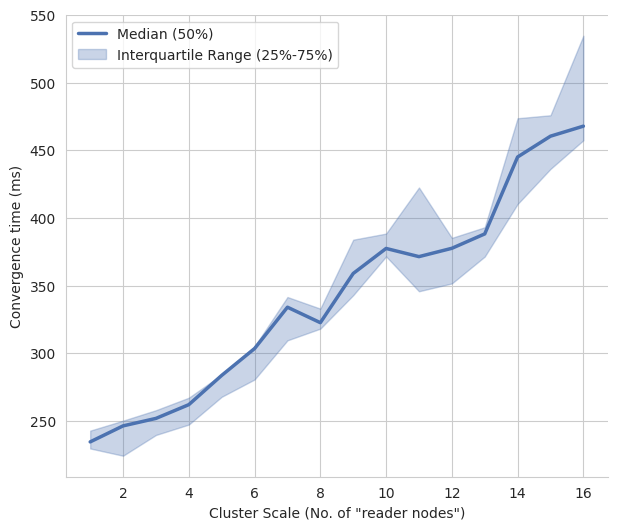

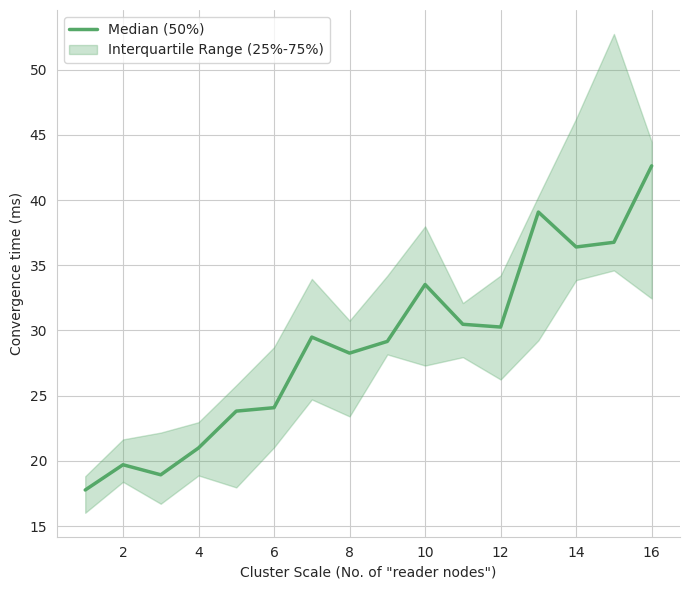

In [9]:
fig1, ax1 = plt.subplots(figsize=(7, 6))
fig2, ax2 = plt.subplots(figsize=(7, 6))

ax1.plot(df['scale'], df['add_p50'], label='Median (50%)', color='#4C72B0', linewidth=2.5)
ax1.fill_between(df['scale'], df['add_p25'], df['add_p75'], color='#4C72B0', alpha=0.3, label='Interquartile Range (25%-75%)')
# ax1.plot(df['scale'], df['add_p99'], label='Tail (P99)', color='#C44E52', linestyle=':', linewidth=2)
#ax1.set_title('Scaling for Add Operations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Convergence time (ms)')
ax1.legend(frameon=True)

# Remove Operations
ax2.plot(df['scale'], df['remove_p50'], label='Median (50%)', color='#55A868', linewidth=2.5)
ax2.fill_between(df['scale'], df['remove_p25'], df['remove_p75'], color='#55A868', alpha=0.3, label='Interquartile Range (25%-75%)')
# ax2.plot(df['scale'], df['remove_p99'], label='Tail (P99)', color='#C44E52', linestyle=':', linewidth=2)
#ax2.set_title('Scaling for Remove Operations', fontsize=14, fontweight='bold')
ax2.set_ylabel('Convergence time (ms)')
ax2.legend(frameon=True)

for ax in [ax1, ax2]:
    ax.set_xlabel('Cluster Scale (No. of "reader nodes")')
    sns.despine(ax=ax) # Clean up top and right borders

plt.tight_layout()
plt.show()

In [10]:
# Save the plots
# bbox_inches='tight' ensures the labels aren't cut off

fig1.savefig("plot-scaling-tests-add.pdf", format="pdf", bbox_inches='tight')

fig2.savefig("plot-scaling-tests-remove.pdf", format="pdf", bbox_inches='tight')